In [13]:
from pettingzoo.mpe import simple_tag_v3

In [14]:
env = simple_tag_v3.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        # this is where you would insert your policy
        action = env.action_space(agent).sample()

    env.step(action)
env.close()

Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5440     |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.00462  |
|    n_updates        | 18       |
----------------------------------
-----------------------------
| time/              |      |
|    episodes        | 8    |
|    fps             | 5404 |
|    time_elapsed    | 0    |
|    total_timesteps | 400  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 12   |
|    fps             | 5384 |
|    time_elapsed    | 0    |
|    total_timesteps | 400  |
-----------------------------
-----------------------------
| time/              |      |
|    episodes        | 16   |
|    fps          

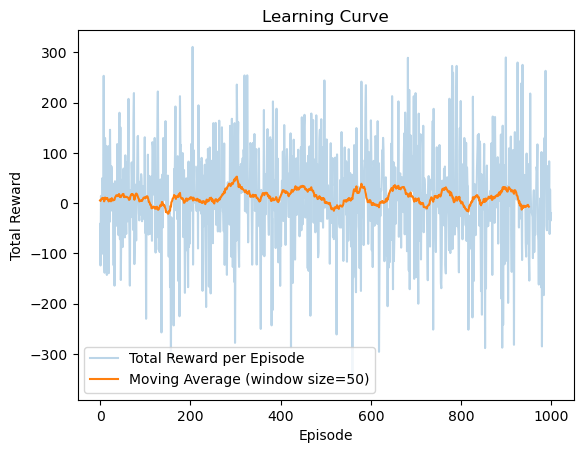

In [23]:
import supersuit as ss
from stable_baselines3 import DQN
from pettingzoo.mpe import simple_tag_v3
from pettingzoo.utils.conversions import aec_to_parallel
import matplotlib.pyplot as plt
import numpy as np

# Inicjalizacja środowiska PettingZoo i konwersja do ParallelEnv
env = simple_tag_v3.env()
parallel_env = aec_to_parallel(env)

# Używanie wrapperów supersuit do wyrównania przestrzeni obserwacji i akcji
parallel_env = ss.pad_observations_v0(parallel_env)
parallel_env = ss.pad_action_space_v0(parallel_env)

# Konwersja środowiska do formatu kompatybilnego z Gym
env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
env = ss.concat_vec_envs_v1(env, 4, num_cpus=1, base_class="stable_baselines3")

# Dostosowanie hiperparametrów modelu DQN
model = DQN('MlpPolicy', env, verbose=1,
            learning_rate=1e-3,
            gamma=0.99,
            exploration_fraction=0.1,
            exploration_final_eps=0.01,
            target_update_interval=1000,
            train_freq=1,
            gradient_steps=1,
            batch_size=32,
            buffer_size=100000)

# Zwiększenie liczby timesteps
model.learn(total_timesteps=10000)

# Testowanie wytrenowanego modelu
obs = env.reset()
total_rewards = []
num_episodes = 1000
for i in range(num_episodes):
    total_reward = 0
    done = [False for _ in range(env.num_envs)]
    while not all(done):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        total_reward += sum(rewards)  # sum of rewards for all agents
    total_rewards.append(total_reward)

env.close()

# Wygładzanie wyników za pomocą średniej kroczącej
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
smoothed_rewards = moving_average(total_rewards, window_size)

# Wizualizacja krzywej uczenia
plt.plot(total_rewards, alpha=0.3, label='Total Reward per Episode')
plt.plot(smoothed_rewards, label=f'Moving Average (window size={window_size})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()
